### Dataset Prepartion
- Read csv file 
- Define dataset into X (input) and Y (output)
- Split dataset (X, Y) into train, test with ratio 7:3
- Feature scaling -> rescale into z = (x-u) / s

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
df.head(3)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0


In [31]:
# Define features (input) and target (output)
X = df.drop('HeartDiseaseorAttack', axis=1).values
y = df['HeartDiseaseorAttack'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Before Scaled Training Features:")
print(X_train[0])

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("\nAfter Scaled Training Features:")
print(X_train[0])

Before Scaled Training Features:
[ 1.  1.  1. 35.  0.  0.  2.  1.  1.  1.  0.  1.  0.  5.  0. 14.  1.  0.
 12.  3.  1.]

After Scaled Training Features:
[ 1.15483331  1.16695813  0.1971837   0.99995662 -0.89235173 -0.20549668
  2.43405003  0.56670248  0.75909525  0.48148954 -0.24392086  0.22739866
 -0.30325285  2.32677679 -0.42994252  1.11566102  2.22256412 -0.88635016
  1.2999631  -2.07622476 -2.4355597 ]


### Define all functions and initial parameters

In [32]:
# Define activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [33]:
# Define the network architecture
input_size = X_train.shape[1]   # Number of input features
hidden_size = 14                # Number of hidden neurons (can be adjusted) -> input_size*2/3
output_size = 1                 # Binary classification

print(f"Input Size: {input_size}, Hidden Size: {hidden_size}, Output Size: {output_size}")


Input Size: 21, Hidden Size: 14, Output Size: 1


In [34]:
def forward_propagation(X, weights):    
    """
    Perform forward propagation.

    Parameters:
    - X: Input data
    - weights: Dictionary containing weights and biases

    Returns:
    - activations: Dictionary containing layer activations
    """
    activations = {}
    # Hidden layer
    z1 = np.dot(X, weights['W1']) + weights['b1']
    a1 = relu(z1)               # range (0, z1)
    activations['z1'] = z1
    activations['a1'] = a1
    
    # Output layer
    z2 = np.dot(a1, weights['W2']) + weights['b2']
    a2 = sigmoid(z2)            # range (0, 1)
    activations['z2'] = z2
    activations['a2'] = a2
    
    return activations


In [35]:
def binary_cross_entropy(y_true, y_pred):
    # To prevent log(0) by define range with np.clip -> value with be in range (epsilon, 1 - epsilon)
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss


In [36]:
class Particle:
    def __init__(self, dimensions):
        # Initialize position and velocity (random)
        self.position = np.random.uniform(-1, 1, dimensions)
        self.velocity = np.random.uniform(- 0.1, 0.1, dimensions)
        self.best_position = self.position.copy()
        self.best_error = float('inf')


In [37]:
class PSO:
    def __init__(self, num_particles, dimensions, inertia=0.5, personal=1.5, group=1.5):
        self.num_particles = num_particles
        self.dimensions = dimensions
        self.inertia = inertia
        self.personal = personal        # c1 (personal learning rate)
        self.group = group              # c2 (group learning rate)
        self.swarm = [Particle(dimensions) for _ in range(num_particles)]
        self.global_best_position = np.random.uniform(-1, 1, dimensions)
        self.global_best_error = float('inf')
        self.cost_history = []
    
    def optimize(self, objective_func, iterations):
        for it in range(iterations):
            for particle in self.swarm:
                # Evaluate current position
                error = objective_func(particle.position)
                
                """
                If new position has fewer error -> select new Position 
                """
                # Update personal best
                if error < particle.best_error:
                    particle.best_error = error
                    particle.best_position = particle.position.copy()
                
                # Update global best
                if error < self.global_best_error:
                    self.global_best_error = error
                    self.global_best_position = particle.position.copy()
            
            self.cost_history.append(self.global_best_error)
            
            for particle in self.swarm:
                """
                Update Velocity:
                v(t+1) = w*v(t) + c1*r1*(personal_best_pos - current_pos) + c2*r2*(global_best_pos - current_pos) 
                """
                r1 = np.random.rand(self.dimensions)        # random value from 0 to 1
                r2 = np.random.rand(self.dimensions)        # random value from 0 to 1

                # c1*r1*(personal_best_pos - current_pos)
                personal_velocity = self.personal * r1 * (particle.best_position - particle.position)
                # c2*r2*(global_best_pos - current_pos)    
                group_velocity = self.group * r2 * (self.global_best_position - particle.position)
                # w*v(t) + c1*r1*(personal_best_pos - current_pos) + c2*r2*(global_best_pos - current_pos) 
                particle.velocity = self.inertia * particle.velocity + personal_velocity + group_velocity
                
                """
                Update Position: x(t+1) = x(t) + v(t+1)
                """
                particle.position += particle.velocity
            
            if it % 100 == 0 or it == iterations - 1:
                print(f"Iteration {it+1}/{iterations}, Global Best Error: {self.global_best_error:.4f}")
        
        return self.global_best_position, self.global_best_error


In [38]:
def unpack_weights(position, input_size, hidden_size, output_size):
    """
    Unpack the flat position vector into weight matrices and bias vectors.

    Parameters:
    - position: Flat array containing all weights and biases
    - input_size: Number of input neurons
    - hidden_size: Number of hidden neurons
    - output_size: Number of output neurons

    Returns:
    - weights: Dictionary containing weight matrices and bias vectors
    """
    weights = {}
    # Calculate the indices for slicing
    W1_end = input_size * hidden_size               # 21+14 = 35
    b1_end = W1_end + hidden_size                   # 35+14 = 49
    W2_end = b1_end + hidden_size * output_size     # 49+14*1 = 63
    b2_end = W2_end + output_size                   # 63+1 = 64
    
    # Extract weights and biases
    weights['W1'] = position[:W1_end].reshape(input_size, hidden_size)          # 35
    weights['b1'] = position[W1_end:b1_end].reshape(1, hidden_size)             # 14
    weights['W2'] = position[b1_end:W2_end].reshape(hidden_size, output_size)   # 14
    weights['b2'] = position[W2_end:b2_end].reshape(1, output_size)             # 1
    
    return weights


In [39]:

def objective_function(position):
    """
    Objective function to minimize: Binary Cross-Entropy loss on training data.

    Parameters:
    - position: Flat array containing all weights and biases

    Returns:
    - loss: Binary cross-entropy loss
    """
    # Define weights and biass vector for each layer
    weights = unpack_weights(position, input_size, hidden_size, output_size)
    """
    Forward prob:
        z1 = X.W1 + b1
        a1 = relu(z1)
        z2 = a1.W2 + b2
        a2 = sigmoid(z2) (predicted output)
    """
    activations = forward_propagation(X_train, weights)
    y_pred = activations['a2'].flatten()
    loss = binary_cross_entropy(y_train, y_pred)
    return loss

In [40]:
# Calculate total number of parameters
W1_size = input_size * hidden_size      # 21*14 = 294
b1_size = hidden_size                   # 14
W2_size = hidden_size * output_size     # 14*1 = 14
b2_size = output_size                   # 1
total_params = W1_size + b1_size + W2_size + b2_size    # 294+14+14+1 = 323

print(f"Total parameters: {total_params}")


Total parameters: 323


### Optmization with Particle Swarm Particle

In [41]:
# PSO parameters
num_particles = 100
iterations = 100
dimensions = total_params

# Initialize PSO
pso = PSO(num_particles=num_particles, dimensions=dimensions)

# Optimize
best_position, best_error = pso.optimize(objective_function, iterations)
print(f"\nBest Error: {best_error}")


Iteration 1/20, Global Best Error: 0.4868
Iteration 20/20, Global Best Error: 0.2631

Best Error: 0.26312218301795776


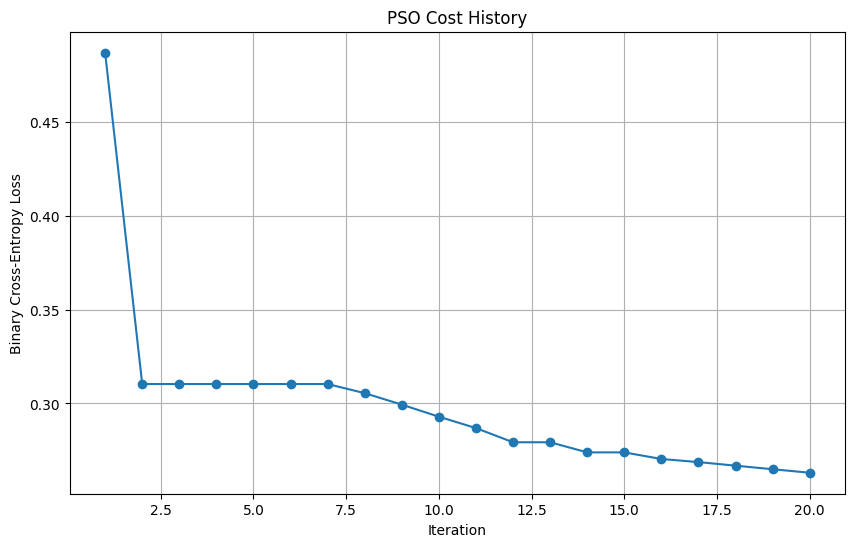

In [45]:
# Plot cost history
plt.figure(figsize=(10,6))
plt.plot(range(1, iterations + 1), pso.cost_history, marker='o')
plt.title('PSO Cost History')
plt.xlabel('Iteration')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True)
plt.show()


### Predict and Calculate accuracy (both Train and Test)

In [42]:
def predict(X, weights):
    activations = forward_propagation(X, weights)
    y_pred = activations['a2'].flatten()
    # Convert probabilities to binary outcomes
    return (y_pred >= 0.5).astype(int)

# Unpack the best weights
best_weights = unpack_weights(best_position, input_size, hidden_size, output_size)

# Predictions on training set
y_train_pred = predict(X_train, best_weights)
train_accuracy = np.mean(y_train_pred == y_train) * 100

# Predictions on testing set
y_test_pred = predict(X_test, best_weights)
test_accuracy = np.mean(y_test_pred == y_test) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy:.2f}%")


Training Accuracy: 90.05%
Testing Accuracy: 90.22%


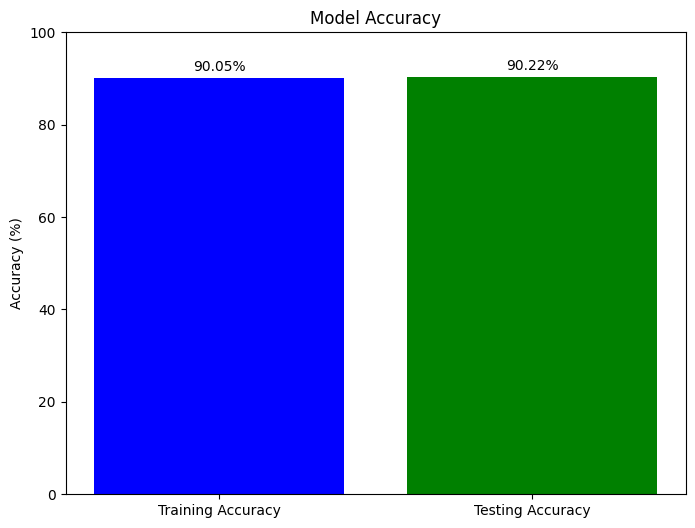

In [46]:
# Plotting training and testing accuracy
labels = ['Training Accuracy', 'Testing Accuracy']
accuracies = [train_accuracy, test_accuracy]

plt.figure(figsize=(8,6))
bars = plt.bar(labels, accuracies, color=['blue', 'green'])
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')

# Adding value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.2f}%', ha='center', va='bottom')

plt.show()


In [43]:
import seaborn as sns

def confusion_matrix(y_true, y_pred):
    """
    Compute confusion matrix for binary classification.

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels

    Returns:
    - matrix: 2x2 confusion matrix
    """
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[TN, FP],
                     [FN, TP]])


def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Compute confusion matrices
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrices
plot_confusion_matrix(train_cm, 'Training Confusion Matrix')
plot_confusion_matrix(test_cm, 'Testing Confusion Matrix')


Training Confusion Matrix:
[[157402   3378]
 [ 14295   2501]]

Testing Confusion Matrix:
[[67579  1428]
 [ 6014  1083]]


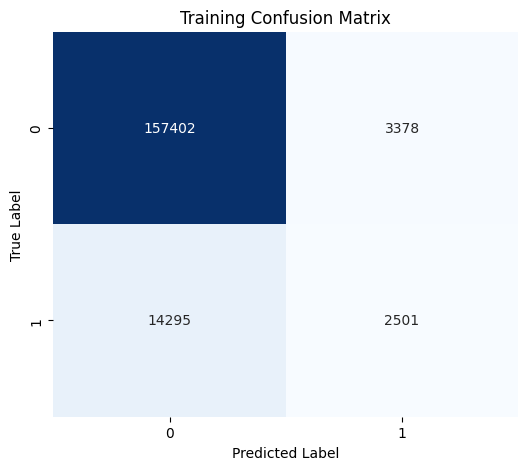

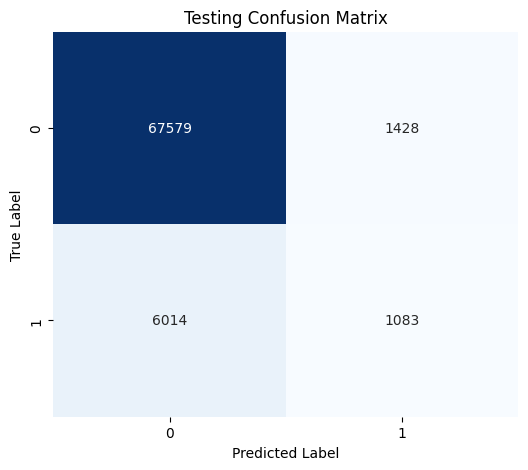

In [47]:
import seaborn as sns

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(train_cm, 'Training Confusion Matrix')
plot_confusion_matrix(test_cm, 'Testing Confusion Matrix')
